In [127]:
import numpy as np
from tools import *
from fitters import *
from plots import *
import seaborn as sns
sns.set_theme()
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
def test_run(noise=0, beta=0, dim=12, e_s=np.array([-0.8, -0.15, 1.5]), a_s=np.array([1.0, 0.2, 0.01]), dt=0.1, sys_rank=-1, iteration=0):

    if sys_rank != -1:
        e_s = e_s[:sys_rank]
        a_s = a_s[:sys_rank]


    time = np.arange(0,3,dt)

    X_series, Y_series, _, _ = build_exp_series(
        a_s, e_s, noise=noise, time =time)

    Y_series = Y_series[dim:]

    # ALGO
    Xhan = build_hankel(X_series, dim)
    X0 = Xhan[:, :-1]
    Xp = Xhan[:, 1:]
    lam = beta * np.eye(dim)

    X0Xp = X0 @ Xp.T
    X0X0 = X0 @ X0.T
    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(
        X0Xp, (X0X0+lam), overwrite_a=True, overwrite_b=True)

    theta = vl[:, np.nanargmax(np.abs(w))]
    w = np.sort(np.abs(w))[::-1]

    theta /= theta[-1]
    pred_eig = theta.real @ Xhan
    pred_eig /= pred_eig[0]/Y_series[0]

    # X Corr
    X_centered = X_series - X_series.mean()
    XXT = np.outer(X_centered, X_centered.T)
    wXXt = np.sort(scipy.linalg.eig(XXT)[0])[::-1]

    result = {
        'Time': time,
        'Y-Time': time[dim:],
        'X_series': X_series,
        'Y_series': Y_series,
        'Pred Eig Left': pred_eig,
        'Eig Vec (REAL)': theta.real,
        'Eig Vec (IMAG)': theta.imag,
        'Eig Vals (MAG)': np.abs(w),
        'Eig Vals (REAL)': w.real,
        'Eig Vals (IMAG)': w.imag,
        'Spec X@XT': wXXt,
        'a_coffs': np.sort(a_s)[::-1]
    }

    return result


In [179]:
params = {
    'noise': [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
    'beta': [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4],
    # 'dt': [0.1, 0.05],
    'sys_rank': [4],
    # 'e_s': np.random.uniform(-1, 1, size=(5, 11)),
    # 'a_s': np.random.uniform(-1, 1, size=(1, 11)),
    'iteration': np.arange(20),
}
# print(params['a_s'])
# print(params['e_s'])
results = param_runner(test_run, params)


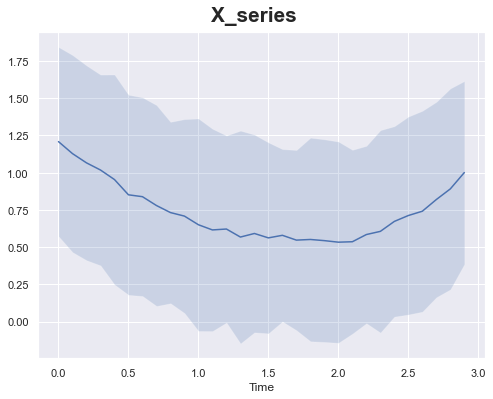

In [180]:
plot_dataframe(results, 'X_series', x_col='Time', aggregate='error', legend=False)

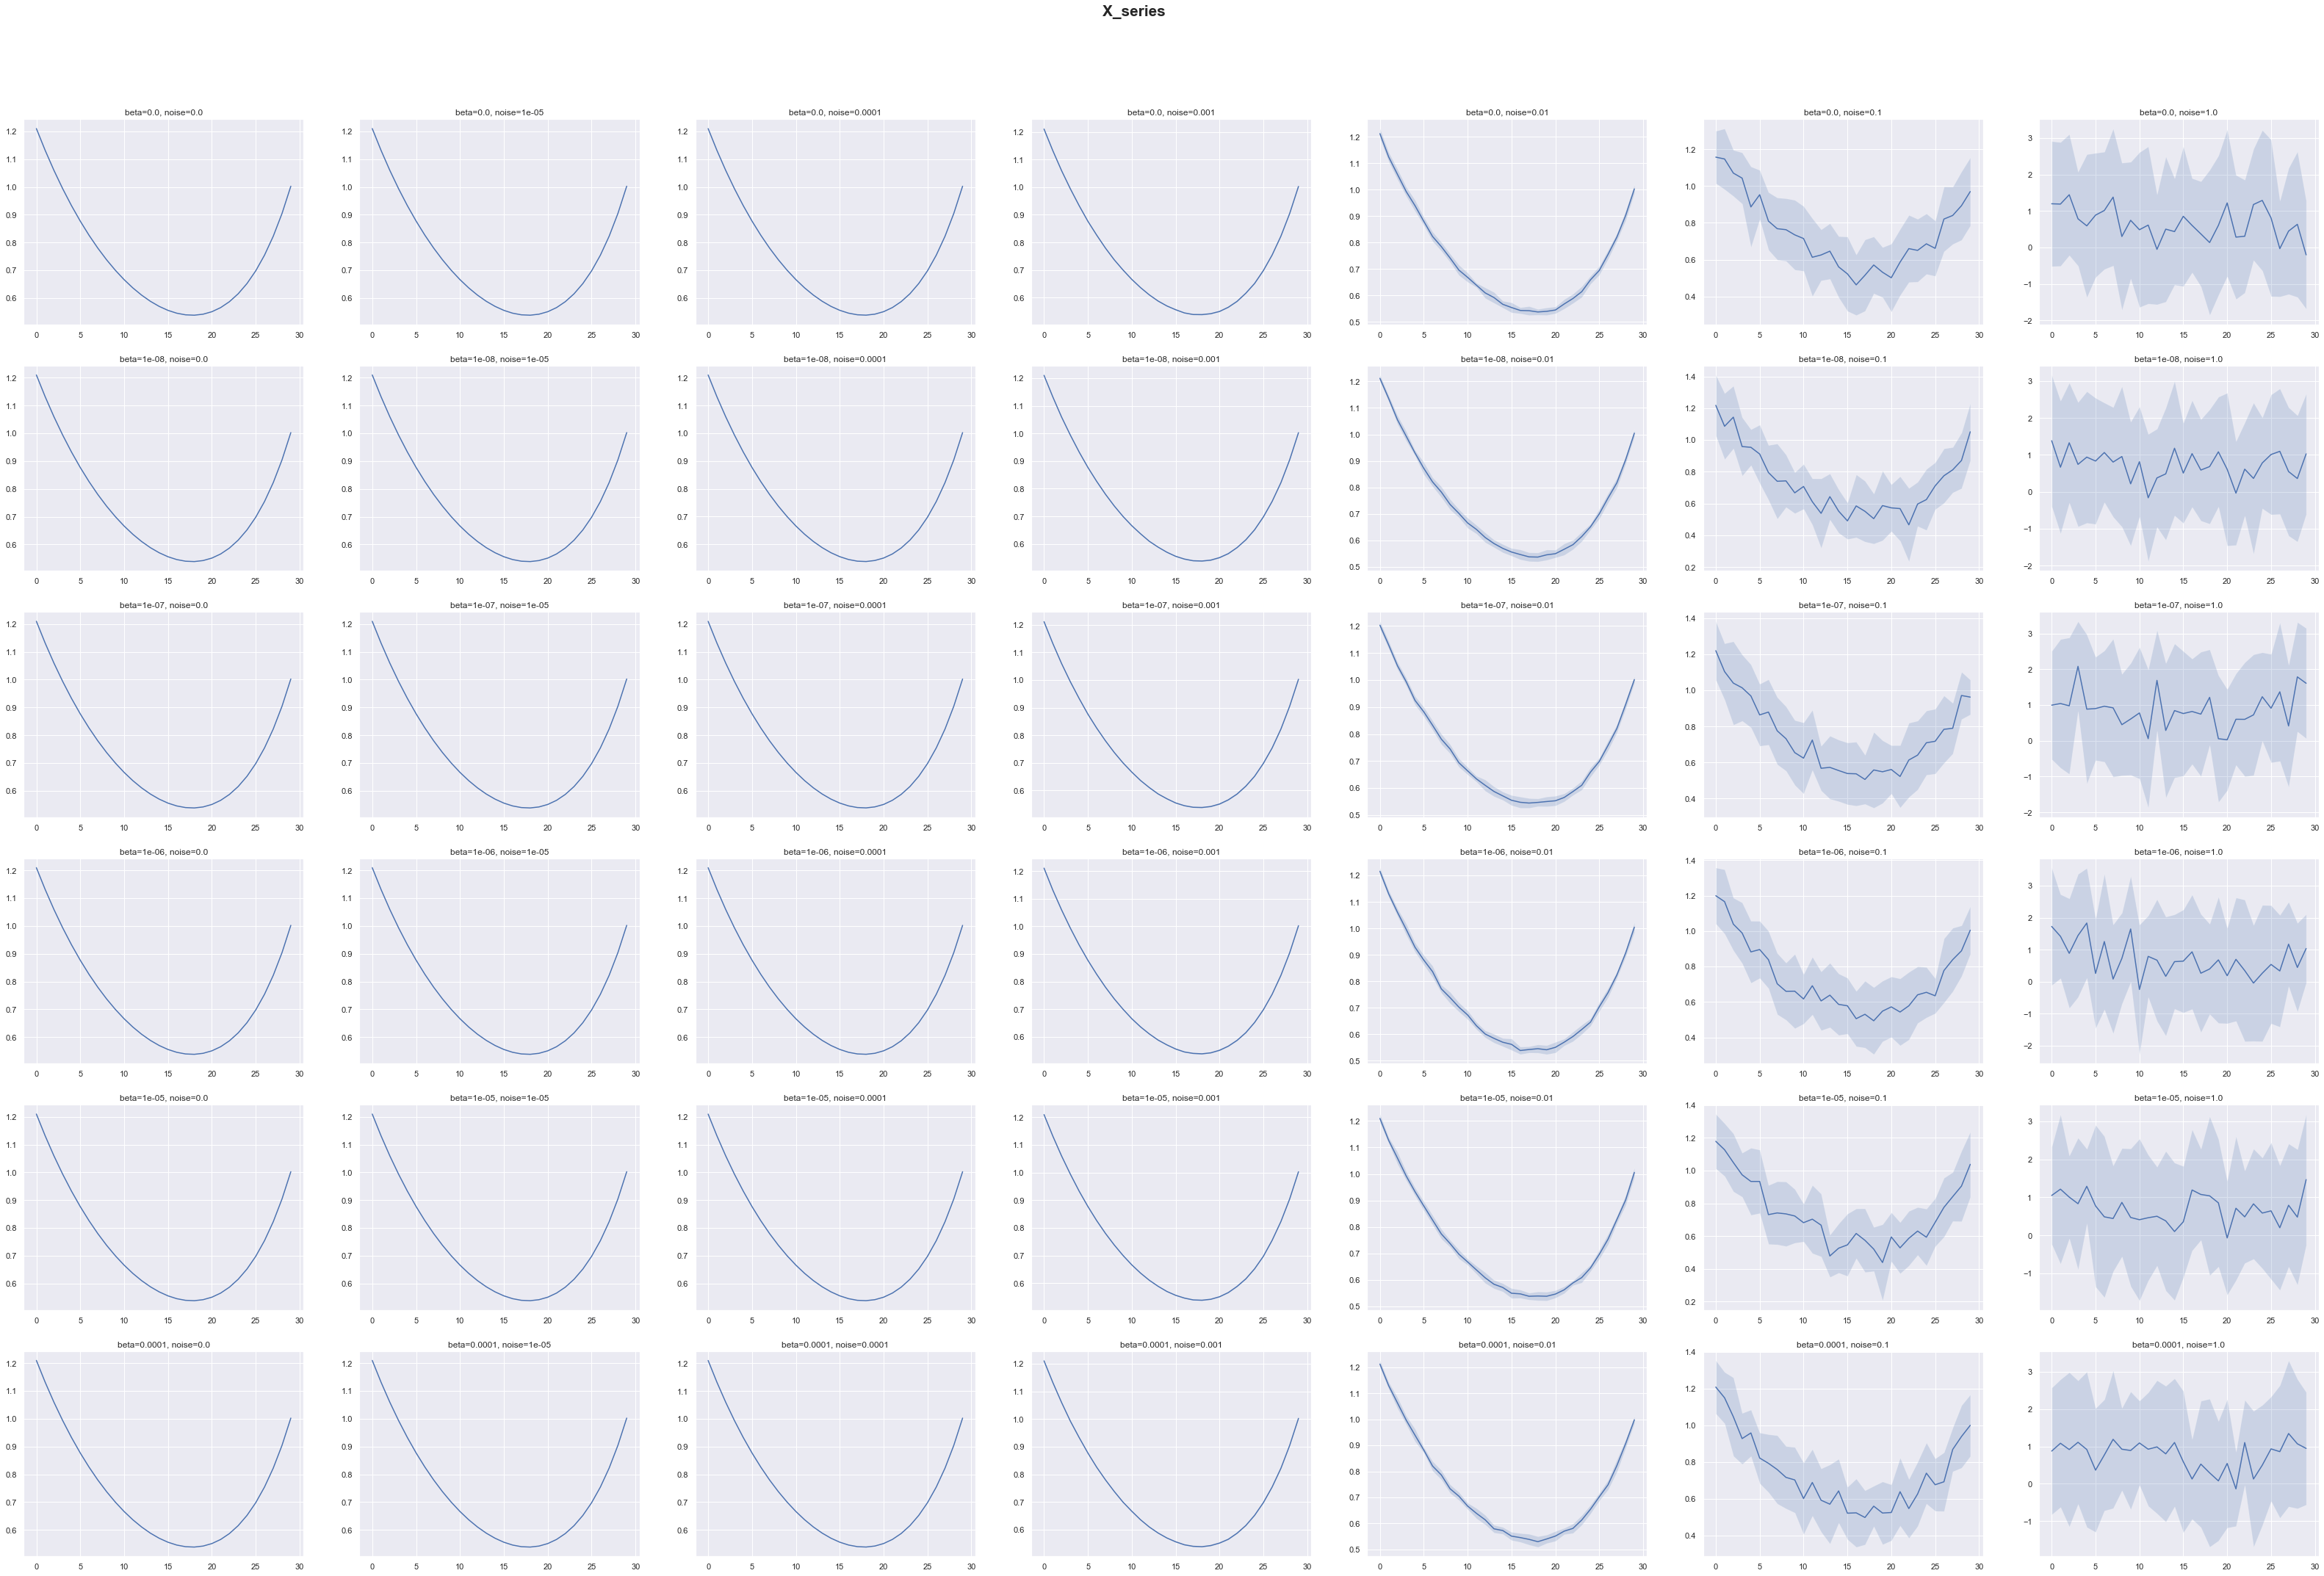

In [181]:
plot_dataframe(results, 'X_series',  line_cols=['noise'], title_cols=['beta', 'noise'], legend=False)

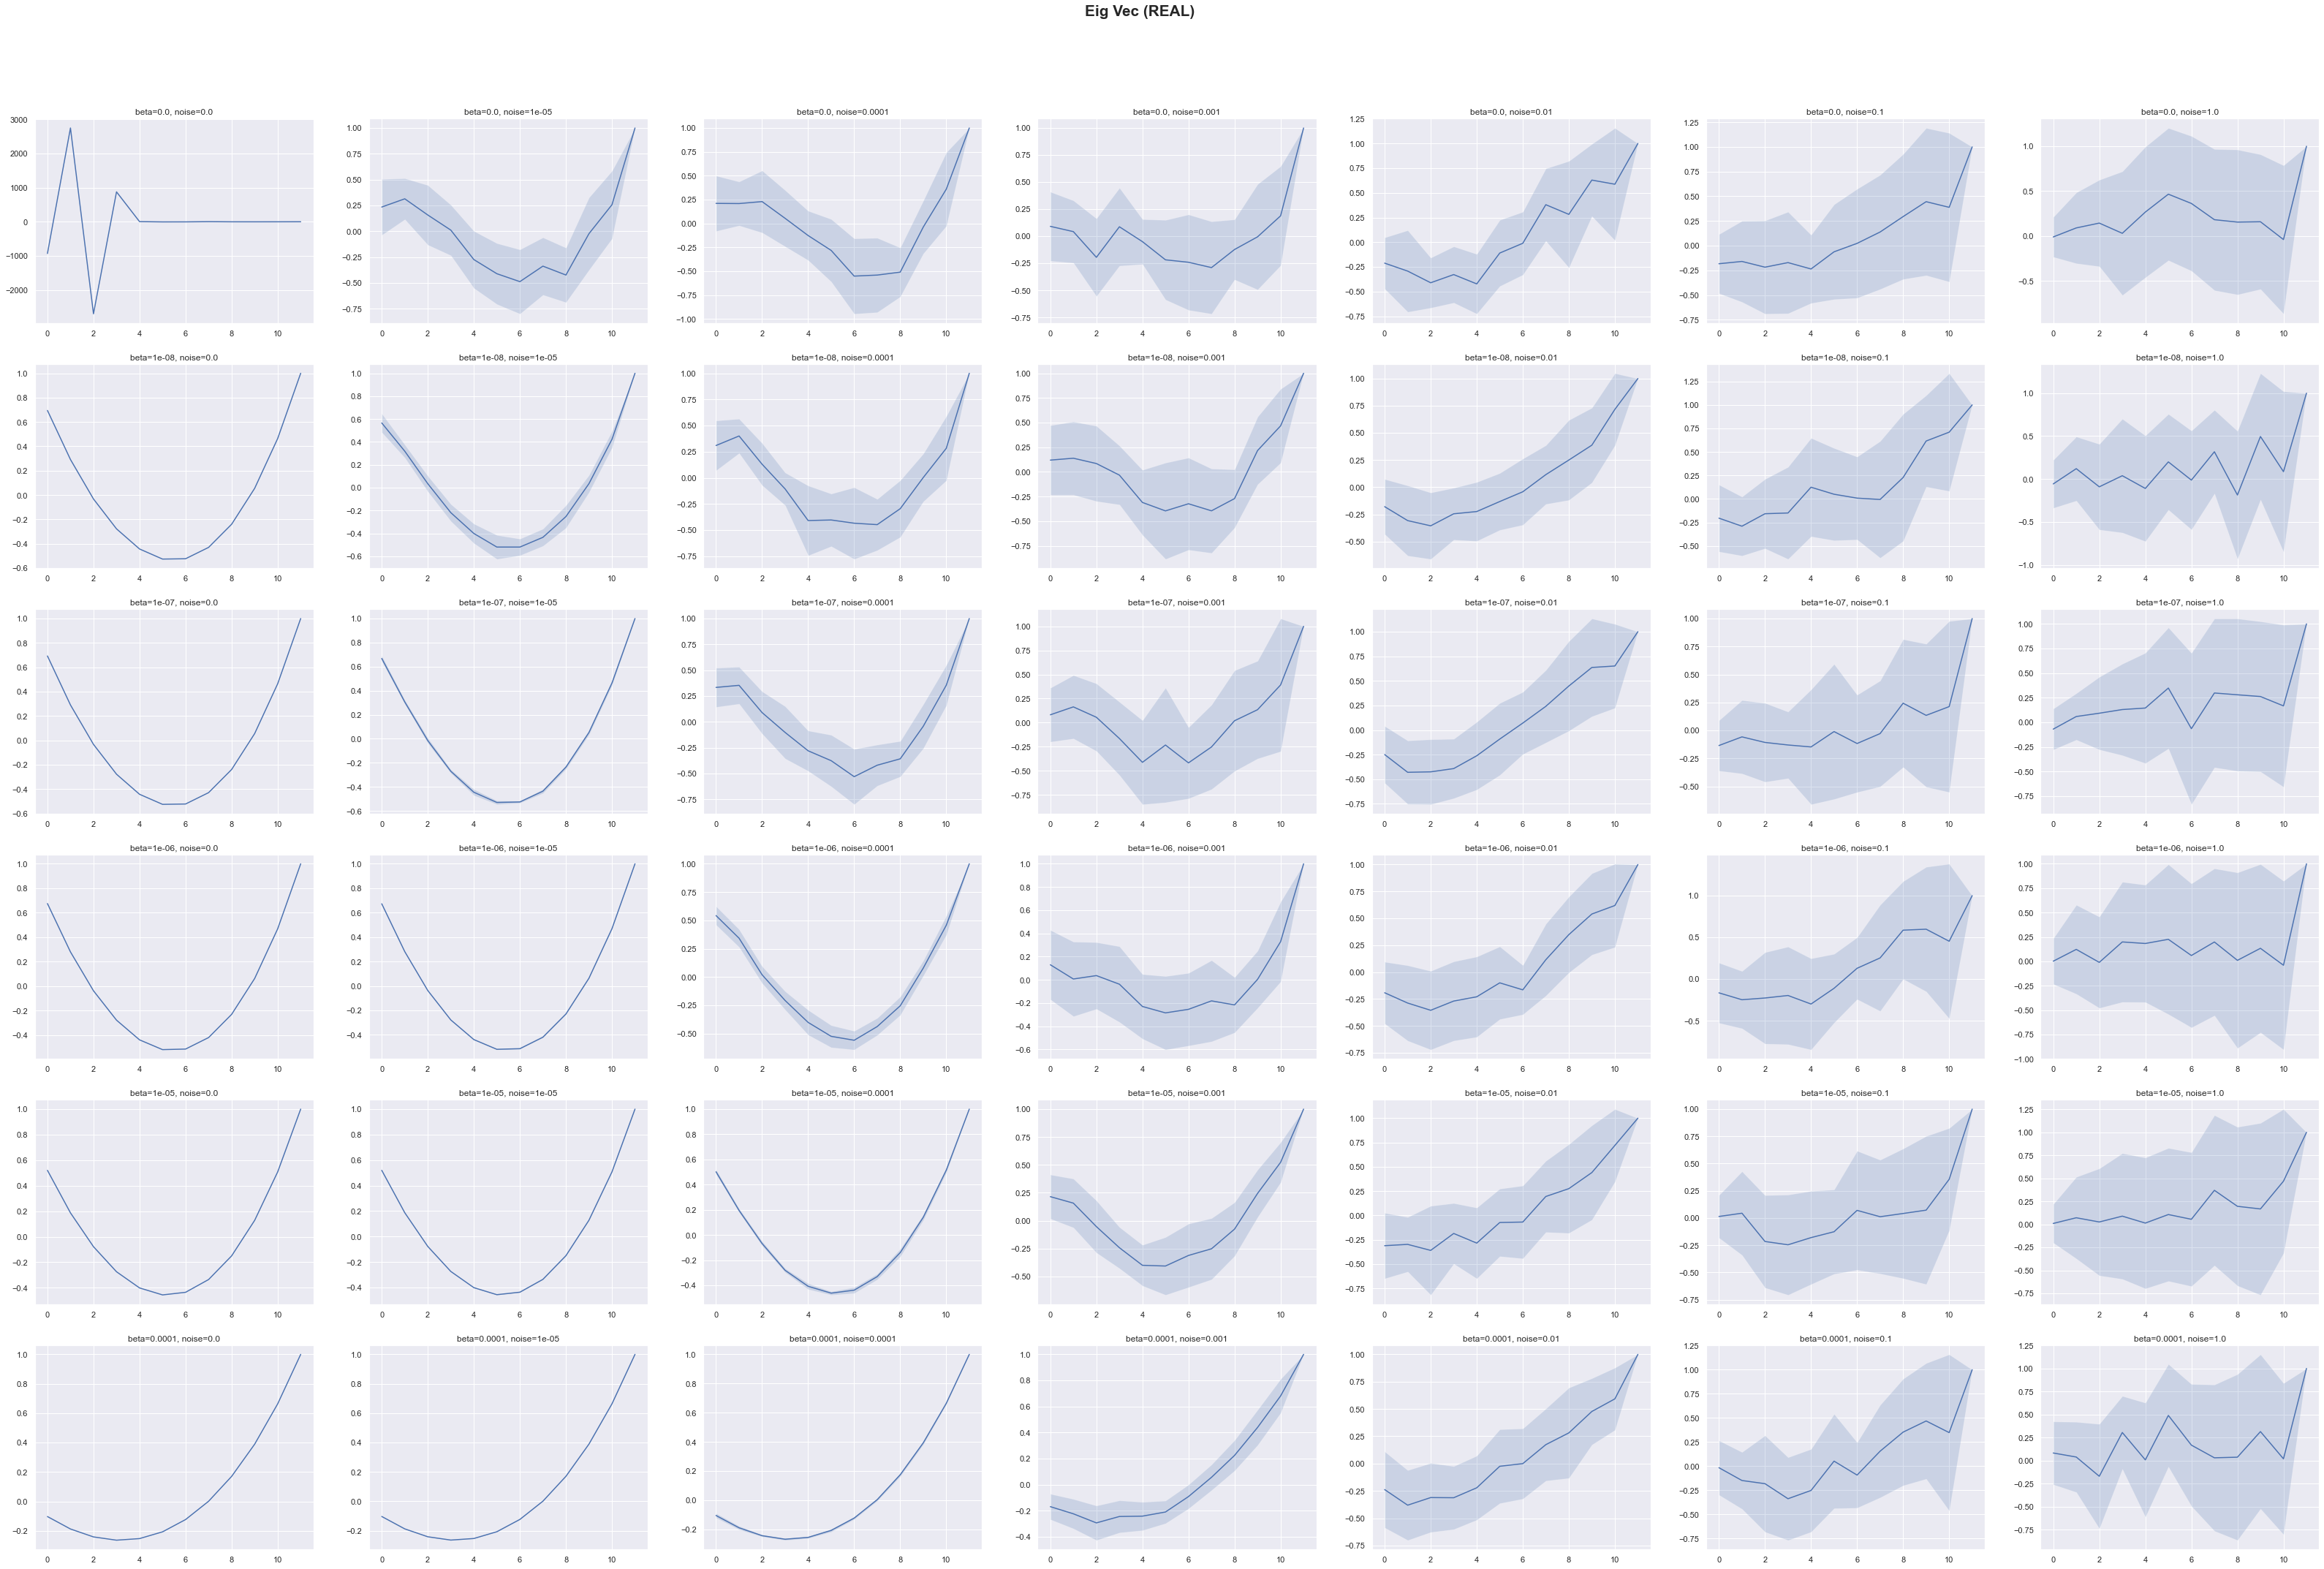

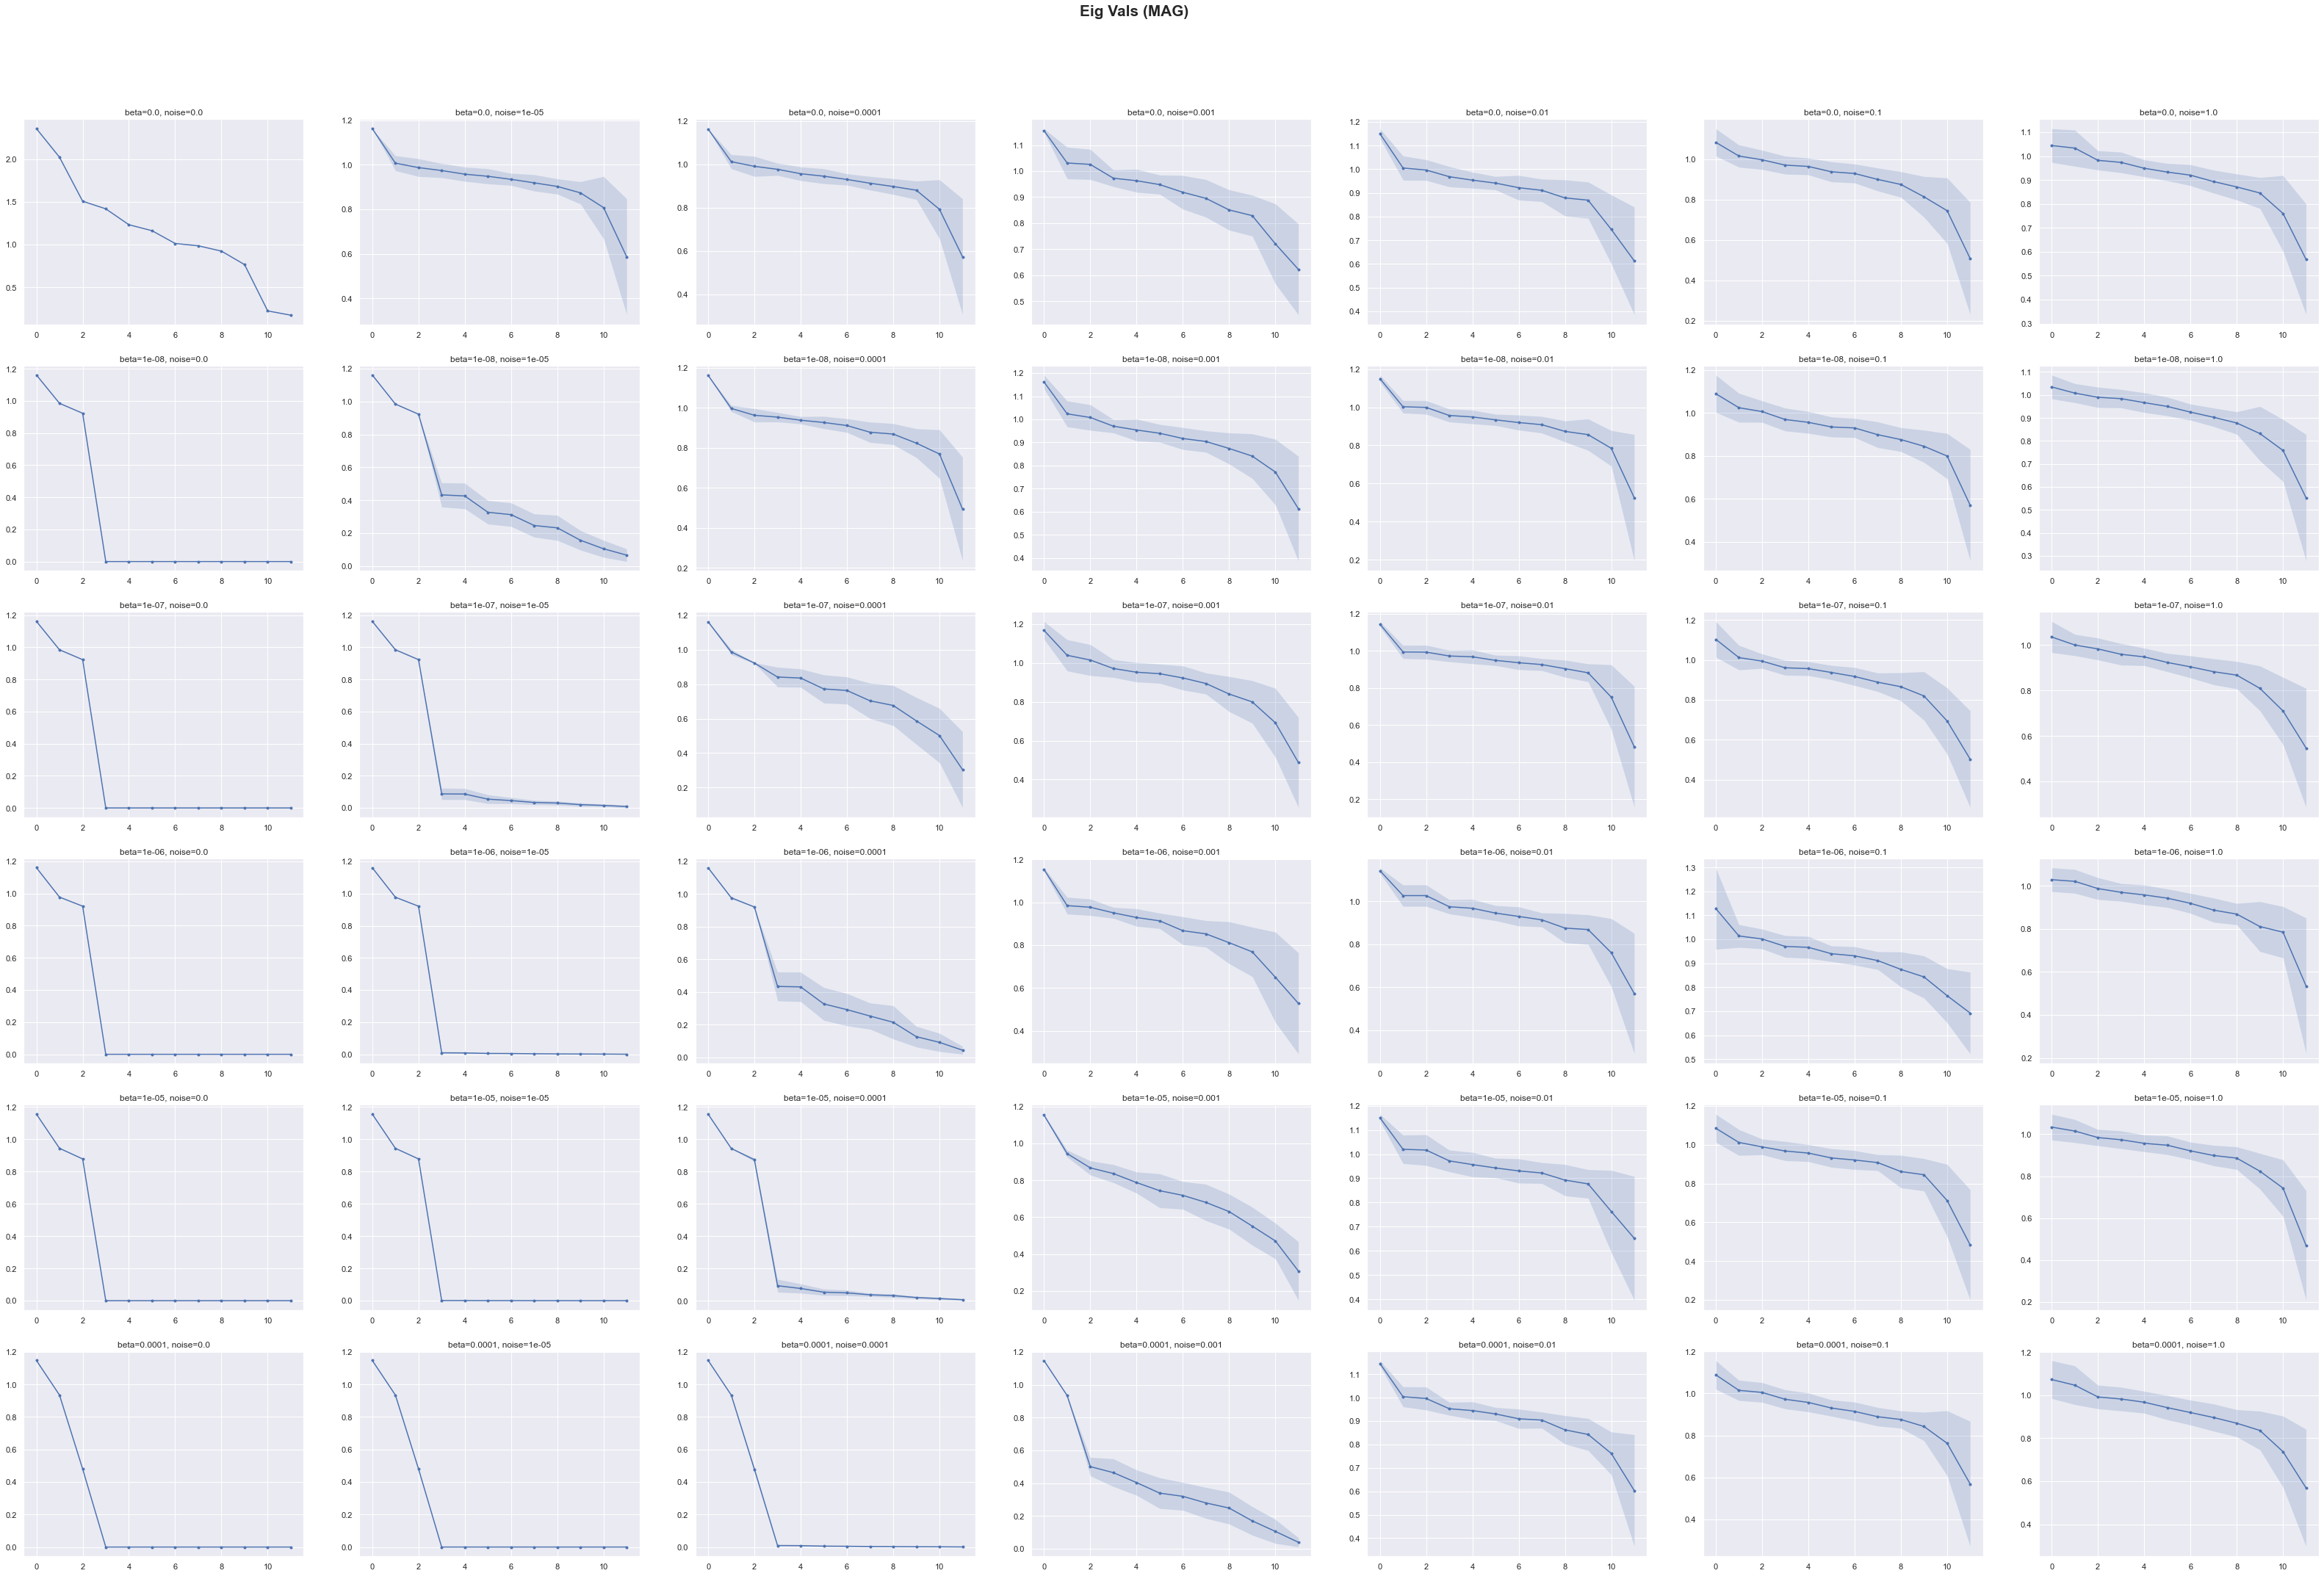

In [182]:
# plot_dataframe(results, ['Pred Eig Left', 'Y_series'], x_col='Y-Time',  line_cols=['e_s', 'a_s'], title_cols=['sys_rank', 'beta', 'noise'], val_styles=[{},['*']], legend=False)
plot_dataframe(results, 'Eig Vec (REAL)',  title_cols=['beta', 'noise'], legend=False)
plot_dataframe(results, 'Eig Vals (MAG)', title_cols=[ 'beta', 'noise'], legend=False,  val_styles=[['.-']])
# plot_dataframe(results, 'Spec X@XT', line_cols=['e_s', 'a_s'], title_cols=['sys_rank', 'beta', 'noise'], legend=False,  val_styles=[['.-']])